<a href="https://colab.research.google.com/github/StefanoRucci/MICN_NN2324/blob/main/MICN_RucciStefano_1794004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook presents an implementation of the **Multi-scale Isometric Convolution Network (MICN)** model, a novel approach for long-term time series forecasting. The MICN model combines the strengths of Convolutional Neural Networks (CNNs) and Transformers by efficiently modeling both local features and global correlations in time series data.

The primary goal is to capture the overall trends and patterns in time series data, addressing both short-term fluctuations and long-term dependencies.


## Motivation

Time series forecasting has a wide range of applications, including sensor network monitoring, weather forecasting, economic and financial analysis, and disease propagation tracking. Traditional methods, like CNNs, are effective at capturing local features but struggle with global dependencies. On the other hand, Transformer-based models excel at modeling long-term dependencies but are computationally expensive due to the attention mechanism. The MICN model aims to bridge this gap by leveraging multi-scale convolutions to capture local and global contexts efficiently.

## MICN Model Overview

The MICN model consists of several key components:

- **Multi-scale Hybrid Decomposition Block**: This block decomposes the input time series into seasonal and trend-cyclical components using different kernel sizes.
- **Seasonal Prediction Block**: This block captures *seasonal patterns* using local and global convolutions, ensuring both local features and global correlations are modeled.
- **Trend-Cyclical Prediction Block**: This block predicts the *trend component* using either linear regression or mean-based methods.

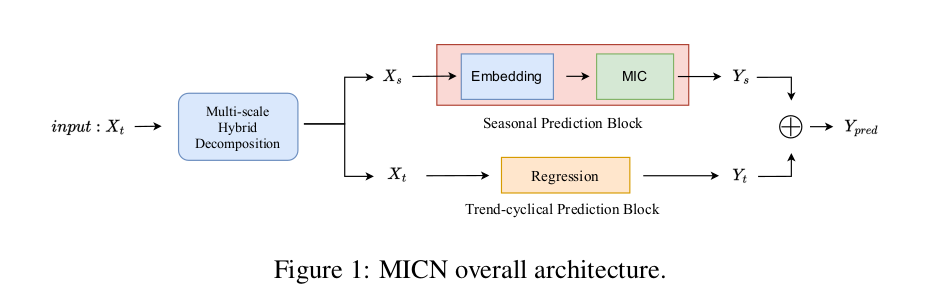

# Prerequisites

## Import Libraries

This section imports the necessary libraries for the implementation. PyTorch is used for building and training the neural network models, `sklearn` for preprocessing and evaluation metrics, `numpy` for numerical operations, `pandas` for data handling, and `matplotlib` for visualization.


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import math
import random
import os
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt

# Model



## Multi-Scale Hybrid Decomposition Network
This **MultiScaleHybridDecomposition** model is designed to separate the trend-cyclical and seasonal components of the time series, using different pooling kernels to capture information at various time scales.

The MHDecomp block is responsible for separating the input time series into seasonal and trend-cyclical components using convolutional operations. It consists of a `SeasonalPredictionBlock` and a `TrendBlock`, which are combined to produce the final output.

- **Formula for Trend Decomposition**:

  $
  \mathbf{X}_t = \text{mean}(\text{AvgPool}(\text{Padding}(\mathbf{X}))_{\text{kernel}=k_1}, \ldots, \text{AvgPool}(\text{Padding}(\mathbf{X}))_{\text{kernel}=k_n})
  $

   $
  \mathbf{X}_s = \mathbf{X} - (\mathbf{X}_t)
  $

  where $(\mathbf{X}_t$) is the trend-cyclical component and $(\mathbf{X}_s$) is the seasonal component.

- **Formula for Final Output**:
  
  $
  \mathbf{Y}_{\text{final}} = \mathbf{Y}_s + \mathbf{Y}_t
  $
  
  where $(\mathbf{Y}_s$) is the output of *seasonal component* and $(\mathbf{Y}_t$) is the output of *trend component*.


In [ ]:
class MultiScaleHybridDecomposition(nn.Module):
    def __init__(self, input_size, embed_dim, scales, num_layers, output_length, output_dim):
        super(MultiScaleHybridDecomposition, self).__init__()
        self.seasonal_block = SeasonalPredictionBlock(input_size, embed_dim, num_time_features=8)
        self.trend_block = MICNRegre(input_size, output_dim)

    def forward(self, x, time_features):
        x_zero = torch.zeros_like(x).float().to(x.device)
        y_s = self.seasonal_block(x, x_zero, time_features)
        y_t = self.trend_block(x.mean(dim=1)).unsqueeze(1).expand(-1, y_s.size(1), -1)
        #print(f"y_t shape: {y_t.shape}")
        y = y_s + y_t
        return y

## Trend-Cyclical Prediction Block

We use a simple **linear regression** strategy to make a prediction on the trend-cyclical component, demonstrating that simple modeling of the trend-cyclical is necessary even for non-stationary series forecasting tasks.

### Linear Regression

  For the trend-cyclical series $( X_t \in \mathbb{R}^{I \times d} $) obtained with the MHDecomp block, the process is as follows:

  $
  Y_{t}^{\text{regre}} = \text{regression}(X_t)
  $

  where
  $( Y_{t}^{\text{regre}} \in \mathbb{R}^{O \times d} $) represents the prediction of the trend part using the linear regression strategy.
  
  We use MICN-regre to represent the MICN model with this trend-cyclic forecasting method.

In [ ]:
class MICNRegre(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MICNRegre, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dropout(x)
        x = self.linear(x)
        return x


### Mean of the Trend-Cyclic Series

  For comparison, we use the mean of $( X_t $) to manage series in which the trend-cyclical component remains constant:

  $
  Y_{t}^{\text{mean}} = \text{mean}(X_t)
  $

  where $( Y_{t}^{\text{mean}} \in \mathbb{R}^{O \times d} $) represents the forecast of the trend part.
  
  We use MICN-means to represent the MICN model with this trend-cyclic forecasting method.

In [ ]:
class MICNMean(nn.Module):
    def __init__(self):
        super(MICNMean, self).__init__()

    def forward(self, x):
        # Calculate the average of the trend-cyclical series
        trend_pred = x.mean(dim=1, keepdim=True).expand(-1, x.size(1), -1)
        return trend_pred

## Seasonal Prediction Block

This class implements the **Seasonal Prediction Block**, which is responsible for modeling the seasonal part of the time series.
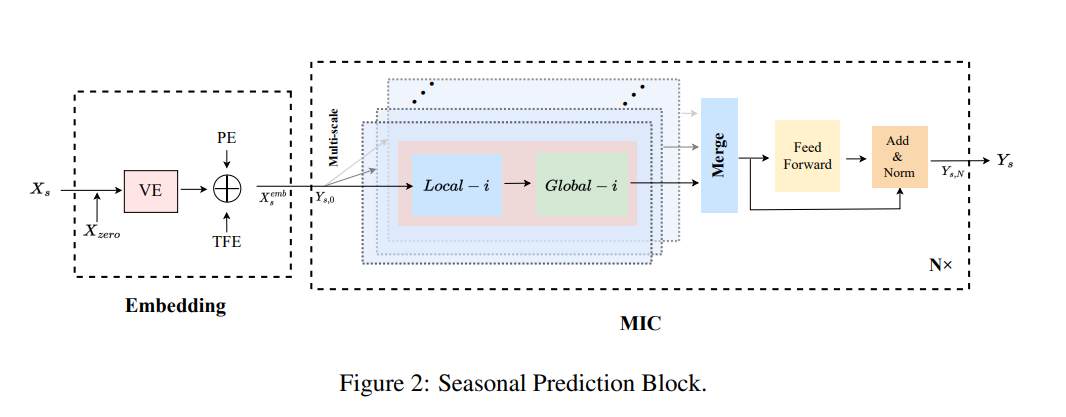

It uses `embedding` layers and multiple `LocalGlobalModule` layers to capture both *local* features and *global* correlations. The final output is passed through a projection layer and then truncated to the correct output length.

- **Formula for Seasonal Prediction**:

  $
  \mathbf{X}_{\text{emb}} = \text{Embedding}(\text{Concat}(\mathbf{X}_s, \mathbf{X}_{\text{zero}}))
  $

  $
  \mathbf{Y}_{s,0} = \mathbf{X}_{\text{emb}}
  $

  $
  \mathbf{Y}_{s,l} = \text{MIC}(\mathbf{Y}_{s,l-1}), \quad l \in \{1, 2, \ldots, N\}
  $

  $
  \mathbf{Y}_s = \text{Truncate}(\text{Projection}(\mathbf{Y}_{s,N}))
  $


### Local Global Module

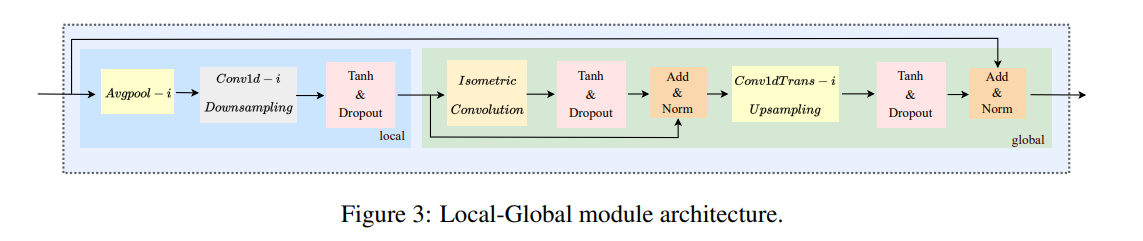

This class implements the `LocalGlobalModule`, which captures both local and global features from the input sequence. It applies local convolutions with a small kernel size and global convolutions with a larger receptive field using dilation. The outputs of both convolutions are combined, normalized, and passed through an activation function.

- **Formula for Local and Global Convolutions**:

  $
  \mathbf{Y}_{\text{local}} = \text{Conv1d}_{\text{local}}(\mathbf{X})
  $
  
  $
  \mathbf{Y}_{\text{global}} = \text{Conv1d}_{\text{global}}(\mathbf{X})
  $

  $
  \mathbf{Y} = \text{Norm}(\mathbf{Y}_{\text{local}} + \mathbf{Y}_{\text{global}})
  $

  $
  \mathbf{Y} = \text{Tanh}(\mathbf{Y})
  $


In [ ]:
class LocalGlobalModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(LocalGlobalModule, self).__init__()
        self.local_conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.global_conv = nn.ConvTranspose1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=stride-1)
        self.norm = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(p=0.1)
        self.activation = nn.Tanh()

    def forward(self, x):
        # Permute to match Conv1d input format (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)
        local_out = self.local_conv(x)
        global_out = self.global_conv(local_out)

        # Handle size mismatch by padding
        if local_out.size(2) != global_out.size(2):
            diff = local_out.size(2) - global_out.size(2)
            if diff > 0:
                global_out = F.pad(global_out, (0, diff))
            else:
                local_out = F.pad(local_out, (0, -diff))
        # Combine local and global outputs
        combined = local_out + global_out
        # Apply normalization
        combined = self.norm(combined.permute(0, 2, 1))
        # Apply dropout
        combined = self.dropout(combined)
        # Apply activation function
        combined = self.activation(combined)
        return combined

### Seasonal Prediction Block

In [ ]:
class SeasonalPredictionBlock(nn.Module):
    def __init__(self, input_size, embedding_dim, num_time_features):
        super(SeasonalPredictionBlock, self).__init__()
        # Embedding layers for value and time features
        self.value_embedding = nn.Linear(input_size * 2, embedding_dim)
        self.time_features_embedding = nn.Linear(num_time_features, embedding_dim)
        # Local and global modules with different kernel sizes
        self.local_global_modules = nn.ModuleList([
            LocalGlobalModule(embedding_dim, embedding_dim, kernel_size=3, stride=3, padding=1),
            LocalGlobalModule(embedding_dim, embedding_dim, kernel_size=5, stride=5, padding=2),
            LocalGlobalModule(embedding_dim, embedding_dim, kernel_size=7, stride=7, padding=3)
        ])
        # Projection layer to map to the original input size
        self.projection = nn.Linear(embedding_dim, input_size)

    def forward(self, x_s, x_zero, time_features):
        # Concatenate original input with zeros along the last dimension
        x_concat = torch.cat((x_s, x_zero), dim=-1)
        #DEBUG: print(f"x_concat shape: {x_concat.shape}")

        # Compute value embedding
        ve = self.value_embedding(x_concat)
        #DEBUG: print(f"ve shape: {ve.shape}")

        # Compute time features embedding
        tfe = self.time_features_embedding(time_features)
        #DEBUG: print(f"tfe shape before slicing: {tfe.shape}")

        # Slice time features to match the sequence length of the input
        tfe = tfe[:, :x_s.size(1), :]
        #DEBUG: print(f"tfe shape after slicing: {tfe.shape}")

        # Combine value embedding and time features embedding
        x_emb = ve + tfe
        #DEBUG: print(f"x_emb shape: {x_emb.shape}")

        # Pass through local and global modules
        y_s = x_emb
        for i, module in enumerate(self.local_global_modules):
            y_s = module(y_s)
            #DEBUG: print(f"y_s shape after local_global_module {i}: {y_s.shape}")

        # Project to the original input size
        y_s = self.projection(y_s)
        #DEBUG: print(f"y_s shape after projection: {y_s.shape}")
        return y_s

# Experiment

- **Optimizer**: Adam
- **Learning Rate**: 0.001
- **Batch Size**: 32
- **Stopping criterion**: Early stopping after 3 epochs without improvements on validation loss
- **Loss Function**: L2 loss (MSE)
- **Evaluation Metrics**: Mean Squared Error (MSE), Mean Absolute Error (MAE)

- **MIC layer**: 1
- **Input length**: 96 for all datasets (36 for ILI)
- **Hyper-parameter \(i\)**: {12, 16}


## Functions to train and evaluate MICN model

### Early Stopping

**Early stopping** is a technique used during model training to prevent overfitting by stopping the training process once the model’s performance on the validation set starts to degrade. This is based on the assumption that after a certain point, the model begins to "memorize" the training data, rather than generalizing from it, which leads to overfitting.

In the current setup, the early stopping mechanism monitors the validation loss during each epoch. If the validation loss does not improve for a certain number of consecutive epochs (defined by the `patience` parameter), the training is halted early to avoid unnecessary computations and overfitting.



In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            #print(f"Validation loss improved from {self.best_loss} to {val_loss}")  # Debug
            self.best_loss = val_loss
            self.counter = 0
        else:
            #print(f"Validation loss did not improve. Counter: {self.counter}")  # Debug
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                #print("Early stopping")  # Debug

### Train Model


The `train_model` function is responsible for training a model over a given number of epochs while tracking both training and validation losses. It uses an **early stopping** mechanism to halt the training process if the validation loss does not improve for a specified number of consecutive epochs (defined by the `patience` parameter).

- **Training Loop**: For each epoch, the model is set to training mode (`model.train()`), and the optimizer performs gradient updates based on the training loss. The output is adjusted using interpolation if necessary.
- **Validation Loss**: After each epoch, the validation loss is computed using the `validate_model` function.
- **Early Stopping**: The early stopping mechanism monitors the validation loss and stops the training if there is no improvement after a specified number of epochs.
- **Loss Plotting**: After training, a plot of the training and validation losses is generated to visualize the model's learning progress.

This function ensures efficient training while preventing overfitting through early stopping and visual feedback on the learning performance.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    early_stopping = EarlyStopping(patience=3)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for x, y, time_features in train_loader:
            x, y, time_features = x.to(device), y.to(device), time_features.to(device)
            optimizer.zero_grad()
            y_pred = model(x, time_features)

            if y_pred.size() != y.size():
                y_pred = F.interpolate(y_pred.permute(0, 2, 1), size=y.size(1)).permute(0, 2, 1)

            y_pred = y_pred.view_as(y)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        avg_val_loss = validate_model(model, val_loader, criterion)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Plotting the training and validation losses
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

### Validate Model

The `validate_model` function is used to evaluate the model's performance on the validation set. It calculates the average validation loss over the entire validation dataset without updating the model's parameters.

- **Evaluation Mode**: The model is set to evaluation mode (`model.eval()`), which disables dropout layers and batch normalization for consistent validation results.
- **No Gradient Calculation**: During validation, gradients are not computed (`torch.no_grad()`) to save memory and computational resources.
- **Prediction and Loss Calculation**: The function processes the input data, generates predictions, adjusts the output shape if necessary using interpolation, and computes the validation loss using the specified criterion.
- **Loss Averaging**: The average validation loss across all batches in the validation set is returned.

This function ensures that the model's performance is accurately measured on the validation data without impacting the model's learned parameters.

In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x, y, time_features in val_loader:
            x, y, time_features = x.to(device), y.to(device), time_features.to(device)
            y_pred = model(x, time_features)

            if y_pred.size() != y.size():
                y_pred = F.interpolate(y_pred.permute(0, 2, 1), size=y.size(1)).permute(0, 2, 1)

            y_pred = y_pred.view_as(y)
            loss = criterion(y_pred, y)
            total_val_loss += loss.item()
    return total_val_loss / len(val_loader)

### Evaluate Model

The `evaluate_model` function is used to assess the model's performance on a test dataset. It computes the Mean Squared Error (MSE) and Mean Absolute Error (MAE) between the predicted and actual values, and generates a plot that compares the model's predictions against the true values for a subset of the data.

- **Evaluation Mode**: The model is set to evaluation mode (`model.eval()`), where layers like dropout are disabled for consistent results.
- **No Gradient Calculation**: No gradients are calculated (`torch.no_grad()`) to optimize memory and computation during evaluation.
- **Loss Calculation**: For each batch, predictions are generated, and the loss between predictions and true values is computed using the specified loss criterion.
- **Prediction vs Actual Plot**: The predictions and actual values are plotted for comparison, providing visual insight into the model's accuracy over time.
- **MSE and MAE**: The function returns both the Mean Squared Error (MSE) and Mean Absolute Error (MAE) as metrics to evaluate the model's performance.

This function helps in visually and quantitatively evaluating how well the model generalizes on unseen data.



In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for x, y, time_features in test_loader:
            x, y, time_features = x.to(device), y.to(device), time_features.to(device)
            y_pred = model(x, time_features)

            if y_pred.size() != y.size():
                y_pred = F.interpolate(y_pred.permute(0, 2, 1), size=y.size(1)).permute(0, 2, 1)

            y_pred = y_pred.view_as(y)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            predictions.append(y_pred.cpu().numpy())
            targets.append(y.cpu().numpy())

    mse = total_loss / len(test_loader)
    mae = mean_absolute_error(np.concatenate(targets).reshape(-1, targets[0].shape[-1]), np.concatenate(predictions).reshape(-1, predictions[0].shape[-1]))

    # Plot predictions vs actuals for a subset of the data
    plt.figure(figsize=(12, 6))
    plt.plot(np.concatenate(targets).reshape(-1, targets[0].shape[-1])[0], label='Actual')
    plt.plot(np.concatenate(predictions).reshape(-1, predictions[0].shape[-1])[0], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Predicted vs Actual Values')
    plt.legend()
    plt.show()

    return mse, mae

## Data Preprocessing

We connect to my Google Drive where there are the datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path_etth1 = '/content/drive/MyDrive/datasets/ETTh1.csv'
file_path_exchange = '/content/drive/MyDrive/datasets/exchange_rate.csv'

In [ ]:
def create_dataloader(data, batch_size):
    X, y, time_features = data
    tensor_data = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(time_features, dtype=torch.float32))
    return DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

### Loading ETTH dataset

Only this dataset has a split_ratio=(0.6, 0.2, 0.2) for *train* *test* and *validate* sets.

In [ ]:
# Function to load data and return trains, vals and test splits
def load_data_etth(file_path, input_length, pred_length, split_ratio=(0.6, 0.2, 0.2)):
    df = pd.read_csv(file_path)

    # Converti timestamp in datetime e estrai caratteristiche utili
    df['date'] = pd.to_datetime(df.iloc[:, 0])
    df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / 23.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / 23.0)
    df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / 30.0)
    df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / 30.0)
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 11.0)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 11.0)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek / 6.0)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek / 6.0)

    numerical_data = df.iloc[:, 1:].values  # Includes all columns except the original timestamp
    time_features = df[['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']].values

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)

    X, y, time_feats = [], [], []
    for i in range(len(scaled_data) - input_length - pred_length):
        X.append(scaled_data[i:i+input_length])
        y.append(scaled_data[i+input_length:i+input_length+pred_length])
        time_feats.append(time_features[i:i+input_length+pred_length])

    X, y, time_feats = np.array(X), np.array(y), np.array(time_feats)
    train_size = int(len(X) * split_ratio[0])
    val_size = int(len(X) * split_ratio[1])
    X_train, y_train, time_train = X[:train_size], y[:train_size], time_feats[:train_size]
    X_val, y_val, time_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size], time_feats[train_size:train_size+val_size]
    X_test, y_test, time_test = X[train_size+val_size:], y[train_size+val_size:], time_feats[train_size+val_size:]

    return (X_train, y_train, time_train), (X_val, y_val, time_val), (X_test, y_test, time_test)


In [ ]:
# Load data and return the length of subdivisions
def load_data_lengths_etth(file_path, input_length, pred_length, split_ratio=(0.6, 0.2, 0.2)):
    df = pd.read_csv(file_path)
    numerical_data = df.iloc[:, 1:].values  # Exclude the timestamp column
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)

    X, y = [], []
    for i in range(len(scaled_data) - input_length - pred_length):
        X.append(scaled_data[i:i+input_length])
        y.append(scaled_data[i+input_length:i+input_length+pred_length])

    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * split_ratio[0])
    val_size = int(len(X) * split_ratio[1])
    test_size = len(X) - train_size - val_size

    return train_size, val_size, test_size

### Loading all datasets

In [ ]:
# Function to load data and return trains, vals and test splits
def load_data(file_path, input_length, pred_length, split_ratio=(0.7, 0.1, 0.2)):
    df = pd.read_csv(file_path)

    # Convert timestamp to datetime and extract useful features
    df['date'] = pd.to_datetime(df.iloc[:, 0])
    df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / 23.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / 23.0)
    df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / 30.0)
    df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / 30.0)
    df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 11.0)
    df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 11.0)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek / 6.0)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek / 6.0)

    numerical_data = df.iloc[:, 1:].values  # Includes all columns except the original timestamp
    time_features = df[['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']].values

    # Normalization
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)

    X, y, time_feats = [], [], []
    for i in range(len(scaled_data) - input_length - pred_length):
        X.append(scaled_data[i:i+input_length])
        y.append(scaled_data[i+input_length:i+input_length+pred_length])
        time_feats.append(time_features[i:i+input_length+pred_length])

    X, y, time_feats = np.array(X), np.array(y), np.array(time_feats)

    # Calculate sizes for train, val, and test splits
    train_size = int(len(X) * split_ratio[0])
    val_size = int(len(X) * split_ratio[1])

    # Split the data into train, val, and test sets
    X_train, y_train, time_train = X[:train_size], y[:train_size], time_feats[:train_size]
    X_val, y_val, time_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size], time_feats[train_size:train_size+val_size]
    X_test, y_test, time_test = X[train_size+val_size:], y[train_size+val_size:], time_feats[train_size+val_size:]

    return (X_train, y_train, time_train), (X_val, y_val, time_val), (X_test, y_test, time_test)


In [ ]:
# Load data and return the length of subdivisions
def load_data_lengths(file_path, input_length, pred_length, split_ratio=(0.7, 0.1, 0.2)):
    df = pd.read_csv(file_path)
    numerical_data = df.iloc[:, 1:].values  # Exclude the timestamp column
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)

    X, y = [], []
    for i in range(len(scaled_data) - input_length - pred_length):
        X.append(scaled_data[i:i+input_length])
        y.append(scaled_data[i+input_length:i+input_length+pred_length])

    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * split_ratio[0])
    val_size = int(len(X) * split_ratio[1])
    test_size = len(X) - train_size - val_size

    return train_size, val_size, test_size



## ETTh

Now we use **ETTh** dataset.

### Load dataset

In [ ]:
# Load the dataset into a DataFrame
df = pd.read_csv(file_path_etth1)

# Display the first few rows of the dataset
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


### Training and test

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# # Load data
train_data, val_data, test_data = load_data_etth(file_path_etth1, input_length=96, pred_length=96)

# Displaying the shape of the datasets to verify
print("Train data shape:", train_data[0].shape, train_data[1].shape, train_data[2].shape)
print("Validation data shape:", val_data[0].shape, val_data[1].shape, val_data[2].shape)
print("Test data shape:", test_data[0].shape, test_data[1].shape, test_data[2].shape)

# Check the size of the dataset subdivisions
train_size, val_size, test_size = load_data_lengths_etth(file_path_etth1, input_length=96, pred_length=96)
print(f"\nNumber of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")
print(f"Number of test samples: {test_size}")

# Create DataLoaders
train_loader = create_dataloader(train_data, batch_size=32)
val_loader = create_dataloader(val_data, batch_size=32)
test_loader = create_dataloader(test_data, batch_size=32)

Train data shape: (10336, 96, 15) (10336, 96, 15) (10336, 192, 8)
Validation data shape: (3445, 96, 15) (3445, 96, 15) (3445, 192, 8)
Test data shape: (3447, 96, 15) (3447, 96, 15) (3447, 192, 8)

Number of training samples: 10336
Number of validation samples: 3445
Number of test samples: 3447


#### TEST WITH SEED: 42 ####

Start Training....
Epoch 1/20, Train Loss: 0.6477806651186279, Val Loss: 0.4556158772773213
Epoch 2/20, Train Loss: 0.3759492493635361, Val Loss: 0.36241369556497643
Epoch 3/20, Train Loss: 0.33536558531386196, Val Loss: 0.3160667620875217
Epoch 4/20, Train Loss: 0.32330242057702857, Val Loss: 0.3030757658459522
Epoch 5/20, Train Loss: 0.3153872291093271, Val Loss: 0.2939779156887973
Epoch 6/20, Train Loss: 0.3106209729847155, Val Loss: 0.2920770912810608
Epoch 7/20, Train Loss: 0.30691404756008656, Val Loss: 0.28727237852635207
Epoch 8/20, Train Loss: 0.3035142400500944, Val Loss: 0.28290447703114263
Epoch 9/20, Train Loss: 0.3000408018428844, Val Loss: 0.289893278921092
Epoch 10/20, Train Loss: 0.29794659532445134, Val Loss: 0.28026341384759657
Epoch 11/20, Train Loss: 0.2950288074396712, Val Loss: 0.28759095403883195
Epoch 12/20, Train Loss: 0.29383318901246547, Val Loss: 0.2793572195978076
Epoch 13/20, Train Loss: 0.2941338902471973, Val Loss: 0.278384

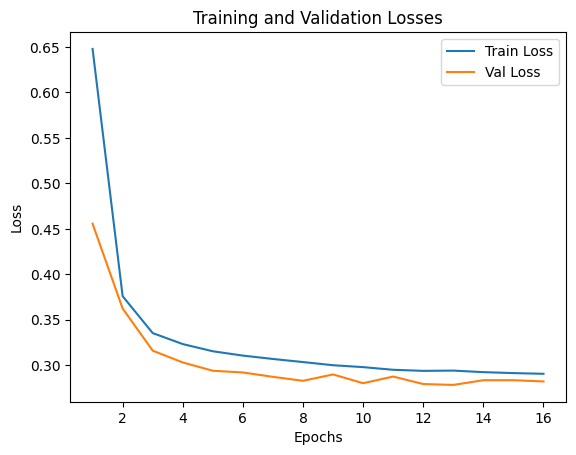


Start Testing....


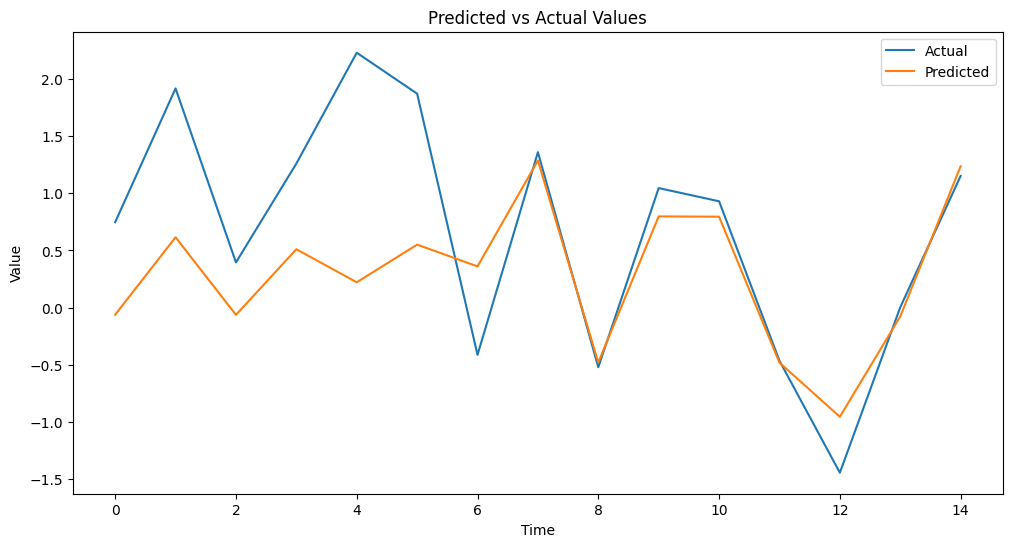

Test MSE: 0.35547031075866137, Test MAE: 0.4020131528377533
#### END TEST #### 

#### TEST WITH SEED: 123 ####

Start Training....
Epoch 1/20, Train Loss: 0.6578567965480935, Val Loss: 0.4474012813082448
Epoch 2/20, Train Loss: 0.3847671950195596, Val Loss: 0.3498540860083368
Epoch 3/20, Train Loss: 0.33703315027357994, Val Loss: 0.3205807625695511
Epoch 4/20, Train Loss: 0.3269672491602115, Val Loss: 0.30479516337315243
Epoch 5/20, Train Loss: 0.3223528811252523, Val Loss: 0.29893346931095477
Epoch 6/20, Train Loss: 0.32130747456853237, Val Loss: 0.29531520743060996
Epoch 7/20, Train Loss: 0.3155609527054955, Val Loss: 0.29758132055953695
Epoch 8/20, Train Loss: 0.3133344297346316, Val Loss: 0.2996370701326264
Epoch 9/20, Train Loss: 0.3097086671059346, Val Loss: 0.29513793783607306
Epoch 10/20, Train Loss: 0.3071583042111559, Val Loss: 0.3008435696915344
Epoch 11/20, Train Loss: 0.3052249852533311, Val Loss: 0.30592965500222313
Epoch 12/20, Train Loss: 0.30026135360677914, Val Loss: 

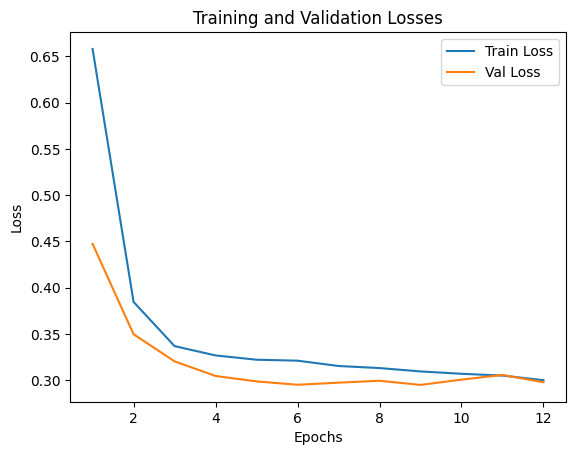


Start Testing....


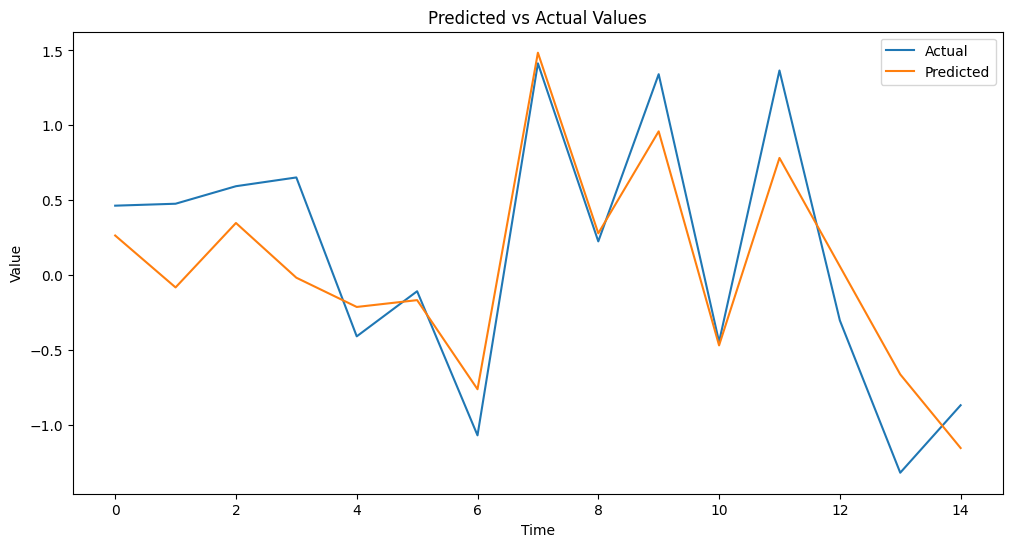

Test MSE: 0.3624254451305778, Test MAE: 0.42373695969581604
#### END TEST #### 

#### TEST WITH SEED: 456 ####

Start Training....
Epoch 1/20, Train Loss: 0.7106473229986965, Val Loss: 0.5274587411571432
Epoch 2/20, Train Loss: 0.41318670044373434, Val Loss: 0.41626786909721514
Epoch 3/20, Train Loss: 0.3615896013499044, Val Loss: 0.343555243478881
Epoch 4/20, Train Loss: 0.32721689343452454, Val Loss: 0.3135865689427764
Epoch 5/20, Train Loss: 0.3162532214871132, Val Loss: 0.30039197703202564
Epoch 6/20, Train Loss: 0.3093455247927007, Val Loss: 0.2952325589678906
Epoch 7/20, Train Loss: 0.30733638794244994, Val Loss: 0.2935838617936329
Epoch 8/20, Train Loss: 0.3054031924843419, Val Loss: 0.28708842438128257
Epoch 9/20, Train Loss: 0.30310912190391553, Val Loss: 0.2884822761019071
Epoch 10/20, Train Loss: 0.3020836419365354, Val Loss: 0.28811612435513073
Epoch 11/20, Train Loss: 0.3009248681297243, Val Loss: 0.29556154018199005
Early stopping


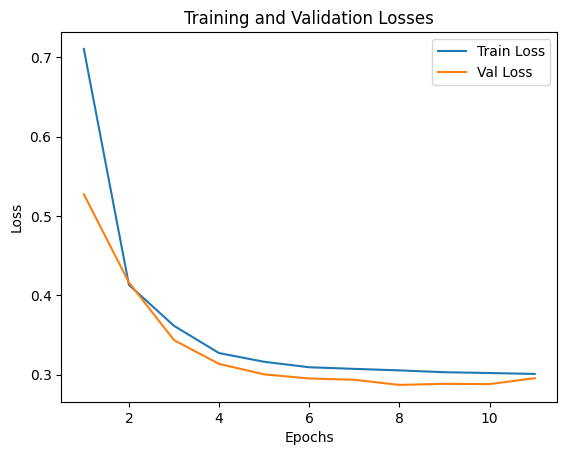


Start Testing....


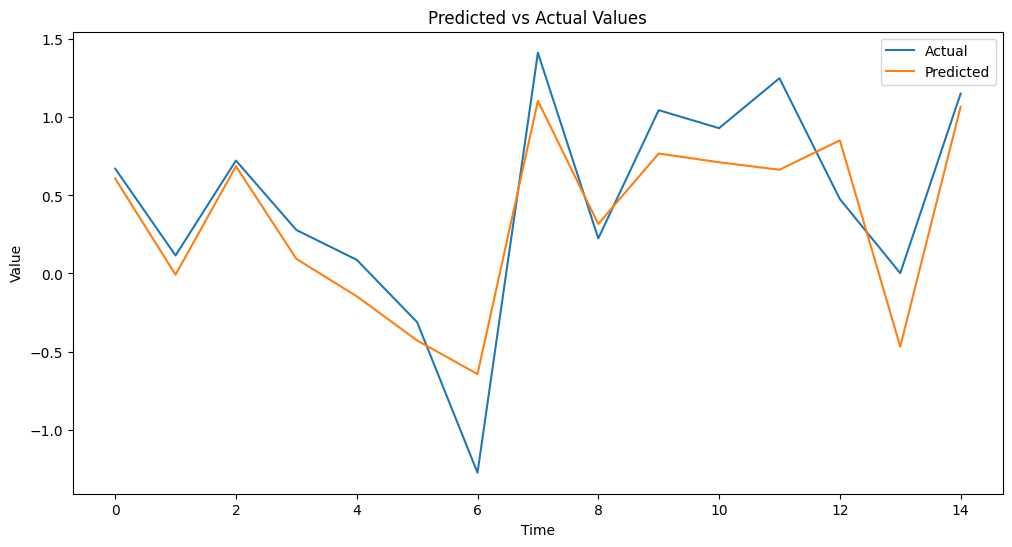

Test MSE: 0.37618647515773773, Test MAE: 0.4163395166397095
#### END TEST #### 

MultiScaleHybridDecomposition(
  (seasonal_block): SeasonalPredictionBlock(
    (value_embedding): Linear(in_features=30, out_features=16, bias=True)
    (time_features_embedding): Linear(in_features=8, out_features=16, bias=True)
    (local_global_modules): ModuleList(
      (0): LocalGlobalModule(
        (local_conv): Conv1d(16, 16, kernel_size=(3,), stride=(3,), padding=(1,))
        (global_conv): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(3,), padding=(1,), output_padding=(2,))
        (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation): Tanh()
      )
      (1): LocalGlobalModule(
        (local_conv): Conv1d(16, 16, kernel_size=(5,), stride=(5,), padding=(2,))
        (global_conv): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(5,), padding=(2,), output_padding=(4,))
        (norm): LayerNorm((16,), eps=1e-05,

In [ ]:
seeds = [42, 123, 456]
results = []

for seed in seeds:
    print(f'#### TEST WITH SEED: {seed} ####')
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Parametri del modello
    input_size = train_data[0].shape[-1]
    output_size = train_data[1].shape[-1]
    embed_dim = 16
    scales = [3, 5, 7]
    num_layers = 3
    output_length = 96
    output_dim = train_data[1].shape[-1]

    # Crea il modello
    model = MultiScaleHybridDecomposition(
        input_size=input_size,
        embed_dim=embed_dim,
        scales=scales,
        num_layers=num_layers,
        output_length=output_length,
        output_dim=output_dim
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization

    # Addestra il modello con validazione
    print('\nStart Training....')
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

    # Valuta il modello
    print('\nStart Testing....')
    mse_micn, mae_micn = evaluate_model(model, test_loader, criterion)
    results.append((mse_micn, mae_micn))

    # Mostra i risultati
    print(f"Test MSE: {mse_micn}, Test MAE: {mae_micn}")

    print('#### END TEST #### \n')

# Visualizza la struttura del modello
print(model)

## Exchange

Now we try with Exchange

### Load dataset

In [ ]:
# Load the dataset into a DataFrame
df = pd.read_csv(file_path_exchange)

# Display the first few rows of the dataset
df.head()


,date,0,1,2,3,4,5,6,OT
0,1990/1/1 0:00,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.525486,0.5930
1,1990/1/2 0:00,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.523972,0.5940
2,1990/1/3 0:00,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.526316,0.5973
3,1990/1/4 0:00,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.523834,0.5970
4,1990/1/5 0:00,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.527426,0.5985


### Training and test

In [ ]:
# Load data
train_data, val_data, test_data = load_data(file_path_exchange, input_length=96, pred_length=96)

# Displaying the shape of the datasets to verify
print("Train data shape:", train_data[0].shape, train_data[1].shape, train_data[2].shape)
print("Validation data shape:", val_data[0].shape, val_data[1].shape, val_data[2].shape)
print("Test data shape:", test_data[0].shape, test_data[1].shape, test_data[2].shape)

# Check the size of the dataset subdivisions
train_size, val_size, test_size = load_data_lengths(file_path_exchange, input_length=96, pred_length=96)
print(f"\nNumber of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")
print(f"Number of test samples: {test_size}")

# Create DataLoaders
train_loader = create_dataloader(train_data, batch_size=32)
val_loader = create_dataloader(val_data, batch_size=32)
test_loader = create_dataloader(test_data, batch_size=32)

Train data shape: (5177, 96, 16) (5177, 96, 16) (5177, 192, 8)
Validation data shape: (739, 96, 16) (739, 96, 16) (739, 192, 8)
Test data shape: (1480, 96, 16) (1480, 96, 16) (1480, 192, 8)

Number of training samples: 5177
Number of validation samples: 739
Number of test samples: 1480


#### TEST WITH SEED: 42 ####

Start Training....
Epoch 1/20, Train Loss: 0.673737695923558, Val Loss: 0.5947866464654604
Epoch 2/20, Train Loss: 0.3637379464911826, Val Loss: 0.40103157982230186
Epoch 3/20, Train Loss: 0.28314531842867535, Val Loss: 0.3208236334224542
Epoch 4/20, Train Loss: 0.25586000370022693, Val Loss: 0.3185625411570072
Epoch 5/20, Train Loss: 0.2426302002535926, Val Loss: 0.3374091958006223
Epoch 6/20, Train Loss: 0.2353943258891871, Val Loss: 0.3268244341015816
Epoch 7/20, Train Loss: 0.22942779903058652, Val Loss: 0.3261079366008441
Early stopping


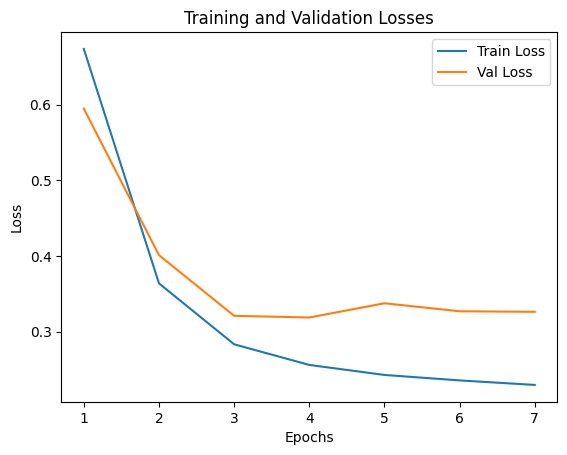


Start Testing....


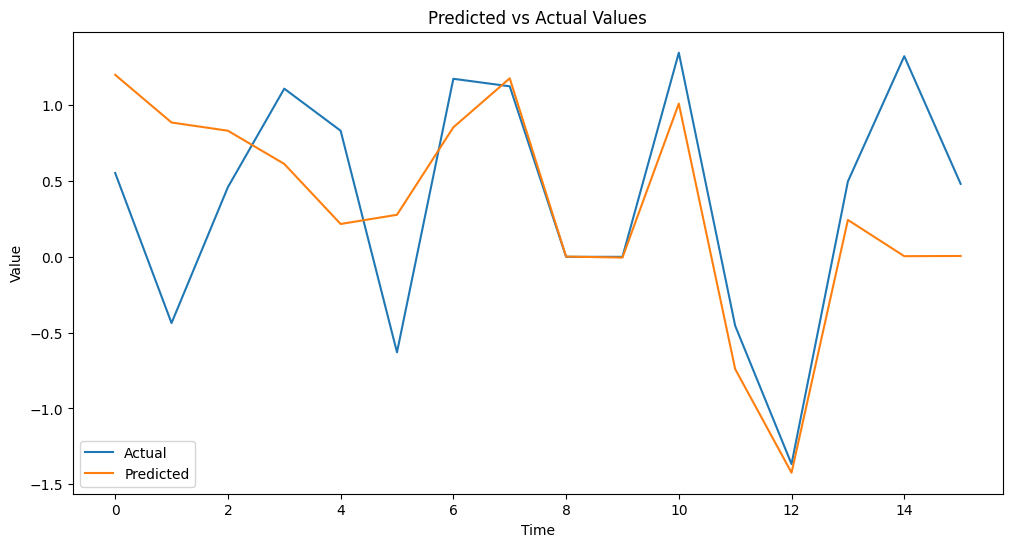

Test MSE: 0.333293451273695, Test MAE: 0.4121469259262085
#### END TEST #### 

#### TEST WITH SEED: 123 ####

Start Training....
Epoch 1/20, Train Loss: 0.6395648649813216, Val Loss: 0.7127451250950495
Epoch 2/20, Train Loss: 0.3225539782900869, Val Loss: 0.3338267095386982
Epoch 3/20, Train Loss: 0.20833014218527593, Val Loss: 0.25322163042922813
Epoch 4/20, Train Loss: 0.17490845651906214, Val Loss: 0.22814063603679338
Epoch 5/20, Train Loss: 0.16053509758210477, Val Loss: 0.20340169096986452
Epoch 6/20, Train Loss: 0.14986931288867822, Val Loss: 0.1849863746513923
Epoch 7/20, Train Loss: 0.13988981616717797, Val Loss: 0.17203494782249132
Epoch 8/20, Train Loss: 0.13339398139052921, Val Loss: 0.16143892084558806
Epoch 9/20, Train Loss: 0.12789452609456617, Val Loss: 0.1644924854238828
Epoch 10/20, Train Loss: 0.12479373522930676, Val Loss: 0.17659075434009233
Epoch 11/20, Train Loss: 0.12233418902313267, Val Loss: 0.1548947828511397
Epoch 12/20, Train Loss: 0.11966743591574976, Val L

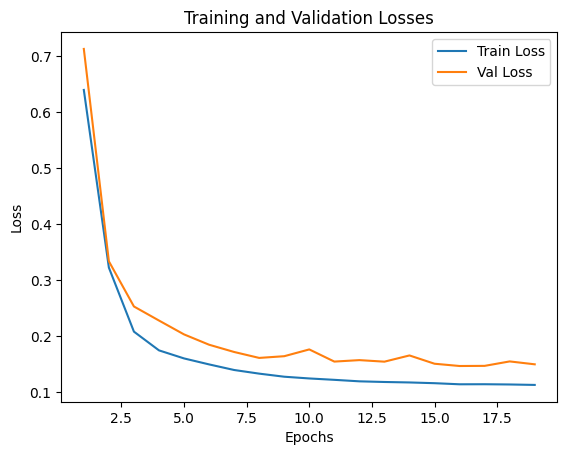


Start Testing....


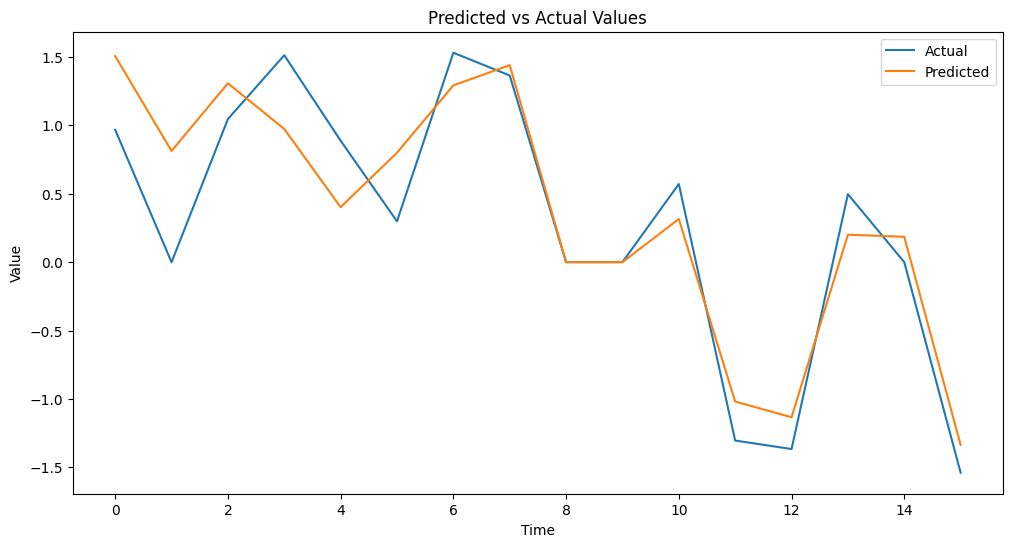

Test MSE: 0.2215285377299532, Test MAE: 0.3239086866378784
#### END TEST #### 

#### TEST WITH SEED: 456 ####

Start Training....
Epoch 1/20, Train Loss: 0.6243256873186723, Val Loss: 0.5205409651001295
Epoch 2/20, Train Loss: 0.282872760001524, Val Loss: 0.2432148220638434
Epoch 3/20, Train Loss: 0.19143747427949198, Val Loss: 0.18747670948505402
Epoch 4/20, Train Loss: 0.1643867219487826, Val Loss: 0.16545487816135088
Epoch 5/20, Train Loss: 0.15055090170583607, Val Loss: 0.1526668289055427
Epoch 6/20, Train Loss: 0.14317006856938938, Val Loss: 0.17638270370662212
Epoch 7/20, Train Loss: 0.13811601261481826, Val Loss: 0.1537204428265492
Epoch 8/20, Train Loss: 0.13340447410757159, Val Loss: 0.1681431190421184
Early stopping


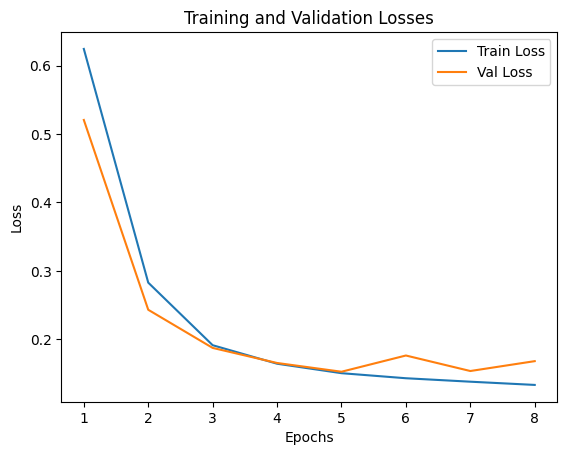


Start Testing....


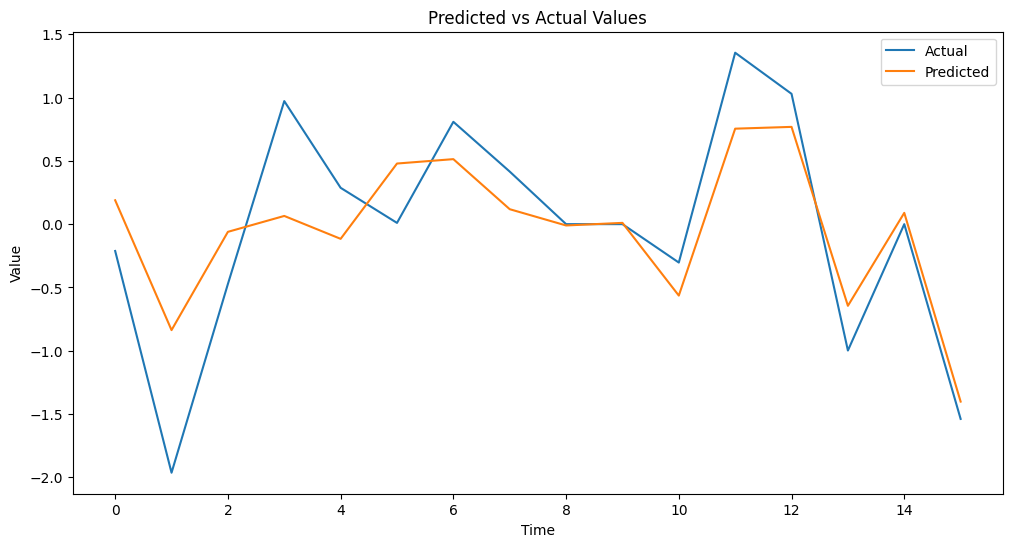

Test MSE: 0.21836441057793637, Test MAE: 0.32581841945648193
#### END TEST #### 

MultiScaleHybridDecomposition(
  (seasonal_block): SeasonalPredictionBlock(
    (value_embedding): Linear(in_features=32, out_features=16, bias=True)
    (time_features_embedding): Linear(in_features=8, out_features=16, bias=True)
    (local_global_modules): ModuleList(
      (0): LocalGlobalModule(
        (local_conv): Conv1d(16, 16, kernel_size=(3,), stride=(3,), padding=(1,))
        (global_conv): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(3,), padding=(1,), output_padding=(2,))
        (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation): Tanh()
      )
      (1): LocalGlobalModule(
        (local_conv): Conv1d(16, 16, kernel_size=(5,), stride=(5,), padding=(2,))
        (global_conv): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(5,), padding=(2,), output_padding=(4,))
        (norm): LayerNorm((16,), eps=1e-05

In [ ]:
seeds = [42, 123, 456]
results = []

for seed in seeds:
    print(f'#### TEST WITH SEED: {seed} ####')
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Model parameters
    input_size = train_data[0].shape[-1]
    output_size = train_data[1].shape[-1]
    embed_dim = 16
    scales = [3, 5, 7]
    num_layers = 3
    output_length = 96
    output_dim = train_data[1].shape[-1]

    # Create model
    model = MultiScaleHybridDecomposition(
        input_size=input_size,
        embed_dim=embed_dim,
        scales=scales,
        num_layers=num_layers,
        output_length=output_length,
        output_dim=output_dim
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization

    # Train model
    print('\nStart Training....')
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

    # Evaluate model
    print('\nStart Testing....')
    mse_micn, mae_micn = evaluate_model(model, test_loader, criterion)
    results.append((mse_micn, mae_micn))

    # Show test results
    print(f"Test MSE: {mse_micn}, Test MAE: {mae_micn}")

    print('#### END TEST #### \n')

# View the model structure
print(model)


# Model Evaluation and Comparison

After successfully training and evaluating our Multi-Scale Hybrid Decomposition (MHDecomp) model on the selected datasets, we proceed to compare its performance against various baseline models. These baseline models serve as benchmarks, allowing us to assess the effectiveness of MHDecomp in capturing complex patterns in time series data.

## The baseline models include:

- **Classical Statistical Methods**:
    - **ARIMA (AutoRegressive Integrated Moving Average)**: A widely-used statistical model for analyzing and forecasting time series data by capturing temporal structures.

- **Machine Learning Models**:
    - **SVR (Support Vector Regression)**: A machine learning model that uses a linear or non-linear function to predict future values based on past data.

- **Deep Learning Models**:
    - **LSTM (Long Short-Term Memory Networks)**: A type of recurrent neural network capable of learning long-term dependencies in sequential data.
    - **CNN (Convolutional Neural Networks)**: Convolutional layers are used to capture spatial hierarchies in time series data.

By comparing MHDecomp against these baseline models, we aim to demonstrate the advantages and potential improvements offered by our approach in terms of prediction accuracy and the ability to handle multi-scale temporal patterns. The performance of each model is evaluated using standard metrics such as Mean Absolute Error (MAE) and Mean Squared Error (MSE).

The results from this comparison will provide insights into how well MHDecomp performs relative to traditional and modern models, highlighting its strengths in forecasting complex time series data.


## ARIMA

  ARIMA is a classical statistical model used for analyzing and forecasting time series data. It combines autoregressive, differencing, and moving average components to model time series data with trends and seasonality.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time

# Function to train and evaluate the ARIMA model
def evaluate_arima(train, test, order):
    history = [x for x in train]
    predictions = list()
    start_time = time.time()  # Start the timer
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])

        # Print progress every 100 iterations
        if t % 100 == 0:
            elapsed_time = (time.time() - start_time) / 60  # Convert to minutes
            print(f'Iteration {t}/{len(test)}, Elapsed time: {elapsed_time:.2f} minutes')

    total_time = (time.time() - start_time) / 60  # Convert to minutes
    print(f"Total time for ARIMA evaluation: {total_time:.2f} minutes")
    return predictions

# Further reduce the size of the dataset
train_subset = train_data[1][:30]  # Use the first 30 samples for training
test_subset = test_data[1][:2]     # Use only 2 samples for testing

# Flatten y_train and y_test for use with ARIMA
train, test = train_subset.flatten(), test_subset.flatten()

# Use a simplified ARIMA model
order = (0, 1, 0)  # Simplified model

# Evaluate the ARIMA model
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    predictions = evaluate_arima(train, test, order)

# Evaluate the metrics
mae_arima = mean_absolute_error(test, predictions)
mse_arima = mean_squared_error(test, predictions)
print(f"ARIMA MAE: {mae_arima}, MSE: {mse_arima}")


Iteration 0/3072, Elapsed time: 0.02 minutes
Iteration 100/3072, Elapsed time: 1.12 minutes
Iteration 200/3072, Elapsed time: 2.15 minutes
Iteration 300/3072, Elapsed time: 3.21 minutes
Iteration 400/3072, Elapsed time: 4.24 minutes
Iteration 500/3072, Elapsed time: 5.28 minutes
Iteration 600/3072, Elapsed time: 6.33 minutes
Iteration 700/3072, Elapsed time: 7.39 minutes
Iteration 800/3072, Elapsed time: 8.45 minutes
Iteration 900/3072, Elapsed time: 9.49 minutes
Iteration 1000/3072, Elapsed time: 10.56 minutes
Iteration 1100/3072, Elapsed time: 11.67 minutes
Iteration 1200/3072, Elapsed time: 12.76 minutes
Iteration 1300/3072, Elapsed time: 13.83 minutes
Iteration 1400/3072, Elapsed time: 14.88 minutes
Iteration 1500/3072, Elapsed time: 15.94 minutes
Iteration 1600/3072, Elapsed time: 17.05 minutes
Iteration 1700/3072, Elapsed time: 18.10 minutes
Iteration 1800/3072, Elapsed time: 19.16 minutes
Iteration 1900/3072, Elapsed time: 20.22 minutes
Iteration 2000/3072, Elapsed time: 21.36 m

### Pro and Cons

| Aspect                    | ARIMA                                           | MICN                                              |
|---------------------------|-------------------------------------------------|---------------------------------------------------|
| **Interpretability**      | High                                            | Low                                               |
| **Training Time**         | Slow, especially with large datasets            | Fast, due to GPU parallelization                  |
| **Pre-processing**        | Necessary (differencing, stationarity)          | Minimal, does not require stationarity            |
| **Series Patterns**       | Better for linear patterns                      | Excels with non-linear and complex patterns       |
| **Scalability**           | Limited without specialized hardware            | High, leverages GPUs for large datasets           |
| **Data Requirement**      | Can work with fewer data                        | Requires large amounts of data                    |
| **Hardware Resources**    | CPU, does not benefit from GPUs                 | Requires GPUs for optimal performance             |
| **Overfitting**           | Less susceptible                                | More susceptible, needs regularization techniques |


## SVR

  SVR is a machine learning model that uses the principles of support vector machines (SVM) for regression tasks. It is effective in capturing non-linear relationships in the data by mapping inputs to high-dimensional feature spaces.

In [ ]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Flatten the feature dimensions of X_train and X_test
X_train_flat = train_data[0].reshape(train_data[0].shape[0], -1)  # Shape: (5177, 96*16)
X_test_flat = test_data[0].reshape(test_data[0].shape[0], -1)     # Shape: (1480, 96*16)

# Correctly reduce y_train and y_test: Average across time steps and features
y_train_avg = train_data[1].mean(axis=(1, 2))  # Shape: (5177,)
y_test_avg = test_data[1].mean(axis=(1, 2))    # Shape: (1480,)

# Function to train and evaluate the SVR model
def evaluate_svr(X_train, y_train, X_test, y_test):
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # You can tweak these parameters
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    return mae, mse

# Evaluate SVR
mae_svr, mse_svr = evaluate_svr(X_train_flat, y_train_avg, X_test_flat, y_test_avg)
print(f"SVR MAE: {mae_svr}, MSE: {mse_svr}")


SVR MAE: 0.22424197961453052, MSE: 0.07807732579117585


### Pro and Cons

| Feature/Aspect          | SVR                                  | MICN                                  |
|-------------------------|--------------------------------------|---------------------------------------|
| **Handling of Time Series Data** | Can handle time series by transforming the data, but not specifically designed for it. | Specifically designed for time series, can capture multi-scale patterns and both linear and non-linear dependencies. |
| **Scalability**         | Scales better than some classical models but can struggle with very large datasets. | Scales well due to its neural network architecture, especially with larger datasets and high-dimensional data. |
| **Model Complexity**    | Medium complexity, requires tuning of kernel and hyperparameters (e.g., `C`, `epsilon`). | High complexity due to deep learning architecture and multiple layers of abstraction. |
| **Feature Engineering** | Requires significant feature engineering to optimize performance. | Handles raw features well, reducing the need for extensive feature engineering. |
| **Training Time**       | Generally faster training on smaller datasets, but can become slow on large datasets. | Typically requires more training time, but leverages parallelism and GPU acceleration effectively. |
| **Prediction Power**    | Effective for linear and slightly non-linear patterns, may struggle with highly complex data. | Excellent at capturing complex, multi-scale patterns in time series data, with strong prediction capabilities. |


## LSTM

  LSTM is a type of recurrent neural network (RNN) capable of learning long-term dependencies in sequential data. It is particularly effective for time series forecasting because it can remember information over long periods, which is crucial for accurate predictions.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # Apply the fully connected layer to all time steps
        return out

# Function to train the LSTM model
def train_lstm(model, train_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Use the correct variables from the dataset
input_dim = train_data[0].shape[2]
hidden_dim = 64
output_dim = train_data[1].shape[2]
num_layers = 2

# Initialize the model, criterion, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a DataLoader from your train_data
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data[0], dtype=torch.float32),
                                               torch.tensor(train_data[1], dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Train the LSTM model
train_lstm(model, train_loader, criterion, optimizer, num_epochs=20)

# Evaluate the LSTM model
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(test_data[0], dtype=torch.float32).to(device))
    mae_lstm = mean_absolute_error(test_data[1].flatten(), predictions.cpu().numpy().flatten())
    mse_lstm = mean_squared_error(test_data[1].flatten(), predictions.cpu().numpy().flatten())
    print(f"LSTM MAE: {mae_lstm}, MSE: {mse_lstm}")


Epoch [1/20], Loss: 0.0924
Epoch [2/20], Loss: 0.0469
Epoch [3/20], Loss: 0.0302
Epoch [4/20], Loss: 0.0235
Epoch [5/20], Loss: 0.0203
Epoch [6/20], Loss: 0.0156
Epoch [7/20], Loss: 0.0147
Epoch [8/20], Loss: 0.0136
Epoch [9/20], Loss: 0.0118
Epoch [10/20], Loss: 0.0107
Epoch [11/20], Loss: 0.0105
Epoch [12/20], Loss: 0.0091
Epoch [13/20], Loss: 0.0076
Epoch [14/20], Loss: 0.0071
Epoch [15/20], Loss: 0.0068
Epoch [16/20], Loss: 0.0063
Epoch [17/20], Loss: 0.0060
Epoch [18/20], Loss: 0.0065
Epoch [19/20], Loss: 0.0050
Epoch [20/20], Loss: 0.0048
LSTM MAE: 0.4068842235614016, MSE: 0.3186945195569407


### Pro and Cons

| **Aspect**                  | **LSTM**                                                                                          | **MICN**                                                                                           |
|-----------------------------|---------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------|
| **Strengths**               | - **Sequential Modeling**: LSTM is specifically designed to capture long-term dependencies in time series data. <br> - **Widely Used**: LSTMs are a well-established and widely-used model for time series forecasting. <br> - **Flexibility**: Can model complex sequential patterns and non-linear relationships. | - **Multi-Scale Capability**: MICN is designed to capture both local and global patterns at multiple scales. <br> - **Integration of Convolutional Techniques**: Uses convolutional layers for efficient pattern extraction across different time scales. <br> - **Effective for Multi-Scale Temporal Patterns**: Specifically designed to handle multi-scale temporal patterns in data. |
| **Weaknesses**              | - **Complexity**: Requires careful tuning of hyperparameters (e.g., hidden units, layers). <br> - **Training Time**: LSTMs can be computationally expensive and slower to train, especially on longer sequences. <br> - **Overfitting**: Susceptible to overfitting if not properly regularized. | - **Model Complexity**: MICN can be more complex to implement and understand due to its hybrid nature. <br> - **Less Generalized**: While effective for certain datasets, it may not generalize as well across all types of time series data. <br> - **Requires Detailed Configuration**: Needs careful design of local-global modules to ensure effective performance. |
| **Performance on Dataset**  | - **Good**: Performs well on datasets with clear sequential dependencies and long-term trends. | - **Excellent**: Excels in capturing multi-scale features and patterns that span different temporal ranges. |
| **Interpretability**         | - **Moderate**: While LSTMs can capture complex patterns, their internal workings can be difficult to interpret. | - **High**: The multi-scale decomposition approach offers more interpretable insights into how different temporal patterns contribute to the prediction. |
| **Suitability**             | - **Best for**: Datasets with strong sequential dependencies and where long-term memory is crucial. | - **Best for**: Datasets with multi-scale temporal patterns, such as those with both short-term fluctuations and long-term trends. |


## CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=2)
        self.fc = nn.Linear(32, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.mean(dim=2)
        x = self.fc(x)
        return x

# Use the train_data variables
X_train = train_data[0]
y_train = train_data[1]
X_test = test_data[0]
y_test = test_data[1]

# Initialize the model, loss function, and optimizer
model = CNNModel(input_dim=X_train.shape[2], output_dim=y_train.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Function to train the CNN model
def train_cnn(model, train_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch[:, -1, :])  # Adjusting to match output dimension
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Train the CNN model
train_cnn(model, train_loader, criterion, optimizer, num_epochs=20)

# Evaluate the CNN model
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    mae_cnn = mean_absolute_error(y_test[:, -1, :].flatten(), predictions.cpu().numpy().flatten())
    mse_cnn = mean_squared_error(y_test[:, -1, :].flatten(), predictions.cpu().numpy().flatten())
    print(f"CNN MAE: {mae_cnn}, MSE: {mse_cnn}")


Epoch [1/20], Loss: 0.3001
Epoch [2/20], Loss: 0.2740
Epoch [3/20], Loss: 0.2953
Epoch [4/20], Loss: 0.2439
Epoch [5/20], Loss: 0.2507
Epoch [6/20], Loss: 0.2387
Epoch [7/20], Loss: 0.1808
Epoch [8/20], Loss: 0.1705
Epoch [9/20], Loss: 0.1476
Epoch [10/20], Loss: 0.1658
Epoch [11/20], Loss: 0.1489
Epoch [12/20], Loss: 0.1413
Epoch [13/20], Loss: 0.1270
Epoch [14/20], Loss: 0.1140
Epoch [15/20], Loss: 0.1124
Epoch [16/20], Loss: 0.1149
Epoch [17/20], Loss: 0.0994
Epoch [18/20], Loss: 0.0941
Epoch [19/20], Loss: 0.0761
Epoch [20/20], Loss: 0.0732
CNN MAE: 0.6405528611260971, MSE: 0.7517627309717801


### Pro and Cons

| **Aspect**                   | **CNN Model**                                                 | **MICN (Multi-Scale Isometric Convolutional Network)**                  |
|------------------------------|---------------------------------------------------------------|-------------------------------------------------------------------------|
| **Architecture Complexity**  | Simpler, with a focus on convolutional layers for feature extraction. | More complex, with multiple convolutional layers and multi-scale processing. |
| **Performance**              | May struggle with capturing long-term dependencies.           | Better suited for capturing both short-term and long-term dependencies due to its multi-scale nature. |
| **Training Time**            | Generally faster to train due to fewer parameters and simpler architecture. | Might take longer to train due to its complex architecture and multi-scale approach. |
| **Handling Temporal Features**| Relies heavily on convolutional filters, which may not effectively capture all temporal dynamics. | Explicitly designed to handle multi-scale temporal features, making it more robust for time-series data. |
| **Flexibility**              | Easier to implement and modify for various tasks.             | More specialized, designed specifically for multi-scale time-series analysis. |
| **Scalability**              | Scales well for tasks with a large amount of data.            | More computationally intensive, may require more resources for large datasets. |
| **Use Case**                 | Suitable for tasks where the primary focus is on pattern recognition within small windows of data. | Ideal for complex time-series forecasting tasks where multi-scale temporal patterns are important. |


# Compare the results

   Model       MAE       MSE
0   MICN  0.325818  0.218364
1   LSTM  0.406884  0.318695
2  ARIMA  1.090969  1.789573
3    SVR  0.224242  0.078077
4    CNN  0.640553  0.751763


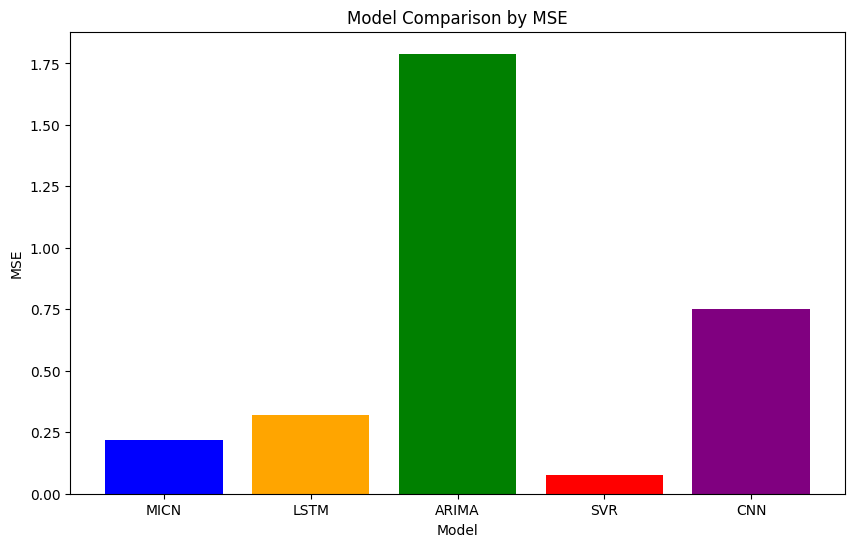

In [ ]:
# Storing the results in a dictionary
results = {
    'Model': ['MICN', 'LSTM', 'ARIMA', 'SVR', 'CNN'],
    'MAE': [mae_micn, mae_lstm, mae_arima, mae_svr, mae_cnn],
    'MSE': [mse_micn, mse_lstm, mse_arima, mse_svr, mse_cnn]
}

# Creating a DataFrame from the results
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

# Creating a bar chart to visualize MSE comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['MSE'], color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Comparison by MSE')
plt.show()
